# Phylogenetic Distance Calculation from RhizCG 2013

Notes: Calculate phylogenetic distance using phylogeny created from rbcL and matK in phylogenerator 20160209_phylogeny.tre.  

In [1]:
%load_ext rpy2.ipython

In [167]:
%%R
library(lsmeans)
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(phyloseq)
library(doParallel)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: estimability

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘lsmeans’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:lmerTest’:

    lsmeans


  res = super(Function, self).__call__(*new_args, **new_kwargs)


## Set file locations

In [3]:
%%R
workDir = '/home/bryan/RhizCG/PhyDist/'
treeFile = '/home/bryan/RhizCG/PhyDist/20160209_phylogeny.tre'
NAMFile = '/home/bryan/RhizCG/PhyDist/NAM_founders_distanceMatrix_v2.txt'

### Read  phyDist expanded table table 

In [275]:
%%R
phy_expand = read.csv(file = "phyDist_expanded.csv", header = TRUE)
head(phy_expand)

      X   FAGES   AMAPO   HELAN   ABUTH   GLYMA   SORBI     B73   ECHCG   SETFA
1 FAGES 0.00000 0.23210 0.25302 0.27096 0.35879 0.43476 0.43787 0.43985 0.43592
2 AMAPO 0.23210 0.00000 0.20952 0.22746 0.31529 0.39126 0.39437 0.39635 0.39242
3 HELAN 0.25302 0.20952 0.00000 0.19116 0.27899 0.35496 0.35807 0.36005 0.35612
4 ABUTH 0.27096 0.22746 0.19116 0.00000 0.24183 0.35370 0.35681 0.35879 0.35486
5 GLYMA 0.35879 0.31529 0.27899 0.24183 0.00000 0.44153 0.44464 0.44662 0.44269
6 SORBI 0.43476 0.39126 0.35496 0.35370 0.44153 0.00000 0.01153 0.03193 0.02800
    ERATE   ELCOR X75.062    Oh7B    MS71     B97     H99   Il14H     Ki3
1 0.44622 0.44745 0.43787 0.43787 0.43787 0.43787 0.43787 0.43787 0.43787
2 0.40272 0.40395 0.39437 0.39437 0.39437 0.39437 0.39437 0.39437 0.39437
3 0.36642 0.36765 0.35807 0.35807 0.35807 0.35807 0.35807 0.35807 0.35807
4 0.36516 0.36639 0.35681 0.35681 0.35681 0.35681 0.35681 0.35681 0.35681
5 0.45299 0.45422 0.44464 0.44464 0.44464 0.44464 0.44464 0.44464 0.44

In [67]:
%%R 
setwd(workDir)
NAMdist = read.table(NAMFile, header = TRUE)
colnames(phy_expand)[12] = "75-062"
head(phy_expand)

        FAGES   AMAPO   HELAN   ABUTH   GLYMA   SORBI     B73   ECHCG   SETFA
FAGES 0.00000 0.23210 0.25302 0.27096 0.35879 0.43476 0.43787 0.43985 0.43592
AMAPO 0.23210 0.00000 0.20952 0.22746 0.31529 0.39126 0.39437 0.39635 0.39242
HELAN 0.25302 0.20952 0.00000 0.19116 0.27899 0.35496 0.35807 0.36005 0.35612
ABUTH 0.27096 0.22746 0.19116 0.00000 0.24183 0.35370 0.35681 0.35879 0.35486
GLYMA 0.35879 0.31529 0.27899 0.24183 0.00000 0.44153 0.44464 0.44662 0.44269
SORBI 0.43476 0.39126 0.35496 0.35370 0.44153 0.00000 0.01153 0.03193 0.02800
        ERATE   ELCOR  75-062    Oh7B    MS71     B97     H99   Il14H     Ki3
FAGES 0.44622 0.44745 0.43787 0.43787 0.43787 0.43787 0.43787 0.43787 0.43787
AMAPO 0.40272 0.40395 0.39437 0.39437 0.39437 0.39437 0.39437 0.39437 0.39437
HELAN 0.36642 0.36765 0.35807 0.35807 0.35807 0.35807 0.35807 0.35807 0.35807
ABUTH 0.36516 0.36639 0.35681 0.35681 0.35681 0.35681 0.35681 0.35681 0.35681
GLYMA 0.45299 0.45422 0.44464 0.44464 0.44464 0.44464 0.44464 0.

In [68]:
%%R
#reorder so that NAMdist is in same order as log2fold change matrix
NAMdist = NAMdist[c(1:6, 8, 7, 9, 10), c(1:6, 8, 7, 9, 10)]

### Use melt to create a dataframe with species by species comparisons that will later be compared with plot by plot unifrac distances

In [69]:
%%R
pd.m = melt(as.matrix(phy_expand))

#set column names and create comparison column
colnames(pd.m) = c("PlantA", "PlantB", "phy_Dist")
pd.m$PlantComp = paste(pd.m$PlantA, pd.m$PlantB, sep = "-")
pd.m %>% head


  PlantA PlantB phy_Dist   PlantComp
1  FAGES  FAGES  0.00000 FAGES-FAGES
2  AMAPO  FAGES  0.23210 AMAPO-FAGES
3  HELAN  FAGES  0.25302 HELAN-FAGES
4  ABUTH  FAGES  0.27096 ABUTH-FAGES
5  GLYMA  FAGES  0.35879 GLYMA-FAGES
6  SORBI  FAGES  0.43476 SORBI-FAGES


# Import phyloseq object and calculate unifrac distances

In [70]:
%%R
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)



physeq.Full = filter_taxa(physeq.Full, function(x) sum(x > 0) > 0, TRUE)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [71]:
%%R
physeq.Full


physeq.Plant = subset_samples(physeq.Full, Plant != "BARE")
sd = sample_data(physeq.Plant)

In [72]:
%%R
#Set up N response table
#Save NResp for joining with subsets of data later

    df = as(sample_data(physeq.Plant), "data.frame")
    df.Nneg <- filter(df, Treatment == "Nneg") %>% .[,c("Plot",  "Biomass_P", "Plant_N", "Plant_CN")]
    df.Npos <- filter(df, Treatment == "Npos") %>% .[,c("Plot",  "Biomass_P", "Plant_N", "Plant_CN")]
    colnames(df.Npos)[2:4] = paste(colnames(df.Npos)[2:4], "Npos", sep = "_")
    
    NResp = left_join(df.Nneg, df.Npos, by = "Plot")
    
    #Calculate fertilizer responses 
    NResp$NResp.B <- NResp$Biomass_P_Npos/NResp$Biomass_P
     NResp$NResp.N <- NResp$Plant_N_Npos/NResp$Plant_N
      NResp$NResp.CN <- NResp$Plant_CN_Npos/NResp$Plant_CN
    NResp = NResp[, c("Plot","NResp.B",  "NResp.N",  "NResp.CN")]
NResp %>% head(4)


  Plot   NResp.B  NResp.N  NResp.CN
1 1.22 0.7084024 1.339137 0.7489281
2 2.02 1.3468200 1.070017 0.9393918
3 4.21 0.9841591 1.251809 0.7858588
4 2.29 1.0408108 1.094700 0.9145053


## Check functional variables for correlations

In [73]:
%%R
colnames(sd)

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[37] "NAG_activity_g"      "BX_rel"              "CB_rel"             
[40] "LAP_rel"             "NAG_rel"             "NO3_ug_g"           
[43] "

In [74]:
%%R
dM = sd[,c("Biomass_P", "tN_p", "Plant_N", "Plant_CN", "SLA", "LNa", "Leaf_N")] %>% 
as.matrix()
Mcor = rcorr(dM, type = "pearson")
Mcor$r

           Biomass_P        tN_p    Plant_N    Plant_CN          SLA
Biomass_P  1.0000000  0.90794176 -0.4765275  0.43644148 -0.194577202
tN_p       0.9079418  1.00000000 -0.2204497  0.09501887 -0.193029881
Plant_N   -0.4765275 -0.22044975  1.0000000 -0.90473115  0.463427365
Plant_CN   0.4364415  0.09501887 -0.9047312  1.00000000 -0.322017461
SLA       -0.1945772 -0.19302988  0.4634274 -0.32201746  1.000000000
LNa       -0.2010049  0.02950892  0.7006501 -0.74420720  0.008214435
Leaf_N    -0.3404970 -0.14570533  0.8595335 -0.81367385  0.545735478
                   LNa     Leaf_N
Biomass_P -0.201004878 -0.3404970
tN_p       0.029508919 -0.1457053
Plant_N    0.700650096  0.8595335
Plant_CN  -0.744207203 -0.8136739
SLA        0.008214435  0.5457355
LNa        1.000000000  0.8321807
Leaf_N     0.832180679  1.0000000


* Plant N and Plant C:N are highly correlated R = .97
* Total N uptake and biomass are highly correlated, but with some independent information R = .88
* leaf %N and plant CN are also highly correlated R = -.91
* Conclusions: use residuals of biomass, N uptake and plant CN; SLA has extra useful information if there are a subset of plants for which it was measured and worth including.  

# Calculate N response variables

## Calculate w-Unifrac distances

In [75]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(physeq.Plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [76]:
%%R
as.matrix(wunif.dist) %>% head

                  sample5-1.22_Nneg sample6-4.12_Npos sample4-1.03_Npos
sample5-1.22_Nneg         0.0000000         0.1829650         0.1722266
sample6-4.12_Npos         0.1829650         0.0000000         0.1882305
sample4-1.03_Npos         0.1722266         0.1882305         0.0000000
sample5-2.06_Npos         0.1902666         0.1828480         0.2140761
sample5-4.08_Npos         0.1757315         0.1141642         0.1765255
sample5-4.28_Npos         0.1457043         0.1784427         0.1774834
                  sample5-2.06_Npos sample5-4.08_Npos sample5-4.28_Npos
sample5-1.22_Nneg         0.1902666         0.1757315         0.1457043
sample6-4.12_Npos         0.1828480         0.1141642         0.1784427
sample4-1.03_Npos         0.2140761         0.1765255         0.1774834
sample5-2.06_Npos         0.0000000         0.1562777         0.1521548
sample5-4.08_Npos         0.1562777         0.0000000         0.1665098
sample5-4.28_Npos         0.1521548         0.1665098         0.

In [77]:
%%R
ud.m = melt(as.matrix(wunif.dist))
head(ud.m) %>% print
dim(ud.m) %>% print
colnames(ud.m) = c("PlotA", "PlotB", "w_Unif_Dist")

#Join with plant names
ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotA" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[4] = "PlantA"

ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotB" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[5] = "PlantB"
ud.m$PlantComp = paste(ud.m$PlantA, ud.m$PlantB, sep = "-")



               Var1              Var2     value
1 sample5-1.22_Nneg sample5-1.22_Nneg 0.0000000
2 sample6-4.12_Npos sample5-1.22_Nneg 0.1829650
3 sample4-1.03_Npos sample5-1.22_Nneg 0.1722266
4 sample5-2.06_Npos sample5-1.22_Nneg 0.1902666
5 sample5-4.08_Npos sample5-1.22_Nneg 0.1757315
6 sample5-4.28_Npos sample5-1.22_Nneg 0.1457043
[1] 30276     3
              PlotA             PlotB w_Unif_Dist  Plant
1 sample5-1.22_Nneg sample5-1.22_Nneg   0.0000000 75-062
2 sample6-4.12_Npos sample5-1.22_Nneg   0.1829650   Oh7B
3 sample4-1.03_Npos sample5-1.22_Nneg   0.1722266  SETFA
4 sample5-2.06_Npos sample5-1.22_Nneg   0.1902666   MS71
5 sample5-4.08_Npos sample5-1.22_Nneg   0.1757315   MS71
6 sample5-4.28_Npos sample5-1.22_Nneg   0.1457043 75-062
              PlotA             PlotB w_Unif_Dist PlantA  Plant
1 sample5-1.22_Nneg sample5-1.22_Nneg   0.0000000 75-062 75-062
2 sample6-4.12_Npos sample5-1.22_Nneg   0.1829650   Oh7B 75-062
3 sample4-1.03_Npos sample5-1.22_Nneg   0.1722266  SETFA 

* How to remove duplicates, ie values above the diagonal?  Possibly a loop that checks if var1-var2 = var2-var1, then remove.

# Join with plant phylogenetic distance, graph phylogenetic distance vs w-unifrac

In [79]:
%%R
Dist = left_join(ud.m, pd.m[,c(3,4)], by = "PlantComp")
tail(Dist) %>% print

#Join with 


                  PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
30271 sample7-4.14_Nneg sample8-3.03_Nneg   0.2893173  SORBI  ELCOR SORBI-ELCOR
30272 sample8-2.07_Npos sample8-3.03_Nneg   0.1777635  ELCOR  ELCOR ELCOR-ELCOR
30273 sample3-4.18_Npos sample8-3.03_Nneg   0.2693146  ABUTH  ELCOR ABUTH-ELCOR
30274 sample8-4.04_Npos sample8-3.03_Nneg   0.2602611   Mo18  ELCOR  Mo18-ELCOR
30275 sample8-2.25_Npos sample8-3.03_Nneg   0.1881618    Ki3  ELCOR   Ki3-ELCOR
30276 sample8-3.03_Nneg sample8-3.03_Nneg   0.0000000  ELCOR  ELCOR ELCOR-ELCOR
      phy_Dist
30271  0.04779
30272  0.00000
30273  0.36639
30274  0.05090
30275  0.05090
30276  0.00000


[1] 30276     7
[1] 30102     7


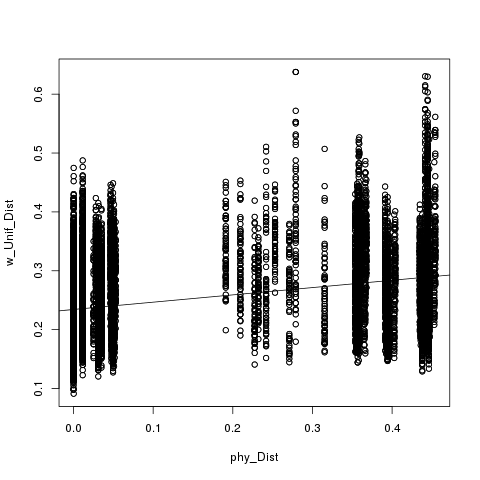

In [80]:
%%R
dim(Dist) %>% print
D.s = filter(Dist, PlotA != PlotB)

dim(D.s) %>% print
plot(w_Unif_Dist~phy_Dist, data = D.s)
m = lm(w_Unif_Dist~phy_Dist, data = D.s)
abline(m)

# Tests with distance from B73

In [90]:
%%R
colnames(B73Means)

[1] "PlotA"       "PlotB"       "w_Unif_Dist" "PlantA"      "PlantB"     
[6] "PlantComp"   "phy_Dist"   


In [108]:
%%R
head(B73dist)

              PlotA             PlotB w_Unif_Dist PlantA PlantB  PlantComp
1 sample6-2.26_Nneg sample5-1.22_Nneg   0.2115773    B73 75-062 B73-75-062
2 sample6-3.18_Nneg sample5-1.22_Nneg   0.2095513    B73 75-062 B73-75-062
3 sample6-4.30_Npos sample5-1.22_Nneg   0.2742233    B73 75-062 B73-75-062
4 sample6-1.12_Npos sample5-1.22_Nneg   0.2737135    B73 75-062 B73-75-062
5 sample6-3.18_Npos sample5-1.22_Nneg   0.2607120    B73 75-062 B73-75-062
6 sample6-2.26_Npos sample5-1.22_Nneg   0.2564857    B73 75-062 B73-75-062
  phy_Dist
1    2e-04
2    2e-04
3    2e-04
4    2e-04
5    2e-04
6    2e-04


In [135]:
%%R

B73dist = Dist %>% filter(PlantA == "B73") 
dim(B73dist) %>% print
PlantDate = sd[,c("DAP", "A_Resid_logB", "A_Resid_logCN", "A_Resid_logN")]
PlantDate$Sample = row.names(PlantDate)
B73dist = left_join(B73dist, PlantDate, by = c("PlotB" = "Sample"))
dim(B73dist) %>% print
head(B73dist)

[1] 1392    7
[1] 1392   11
              PlotA             PlotB w_Unif_Dist PlantA PlantB  PlantComp
1 sample6-2.26_Nneg sample5-1.22_Nneg   0.2115773    B73 75-062 B73-75-062
2 sample6-3.18_Nneg sample5-1.22_Nneg   0.2095513    B73 75-062 B73-75-062
3 sample6-4.30_Npos sample5-1.22_Nneg   0.2742233    B73 75-062 B73-75-062
4 sample6-1.12_Npos sample5-1.22_Nneg   0.2737135    B73 75-062 B73-75-062
5 sample6-3.18_Npos sample5-1.22_Nneg   0.2607120    B73 75-062 B73-75-062
6 sample6-2.26_Npos sample5-1.22_Nneg   0.2564857    B73 75-062 B73-75-062
  phy_Dist DAP A_Resid_logB A_Resid_logCN A_Resid_logN
1    2e-04  72   -0.4251123     0.5695096   -0.9552604
2    2e-04  72   -0.4251123     0.5695096   -0.9552604
3    2e-04  72   -0.4251123     0.5695096   -0.9552604
4    2e-04  72   -0.4251123     0.5695096   -0.9552604
5    2e-04  72   -0.4251123     0.5695096   -0.9552604
6    2e-04  72   -0.4251123     0.5695096   -0.9552604


In [177]:
%%R
B73dist$timedist = abs(79 - B73dist$DAP)
fit = lm(w_Unif_Dist~timedist + phy_Dist, data = B73dist)
anova(fit)
summary(fit)


Call:
lm(formula = w_Unif_Dist ~ timedist + phy_Dist, data = B73dist)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.244509 -0.046381 -0.007747  0.037927  0.241914 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.445e-01  2.652e-03  92.203  < 2e-16 ***
timedist    -4.644e-05  2.500e-04  -0.186    0.853    
phy_Dist     1.096e-01  1.593e-02   6.877 9.22e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06808 on 1389 degrees of freedom
Multiple R-squared:  0.06345,	Adjusted R-squared:  0.06211 
F-statistic: 47.05 on 2 and 1389 DF,  p-value: < 2.2e-16



In [143]:
%%R
B73dist$PlantB %>% levels

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 


In [ ]:
## Do residuals predict distance from B73

In [272]:
%%R
str(B73dist)

'data.frame':	1392 obs. of  12 variables:
 $ PlotA        : chr  "sample6-2.26_Nneg" "sample6-3.18_Nneg" "sample6-4.30_Npos" "sample6-1.12_Npos" ...
 $ PlotB        : chr  "sample5-1.22_Nneg" "sample5-1.22_Nneg" "sample5-1.22_Nneg" "sample5-1.22_Nneg" ...
 $ w_Unif_Dist  : num  0.212 0.21 0.274 0.274 0.261 ...
 $ PlantA       : Factor w/ 22 levels "75-062","ABUTH",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ PlantB       : Factor w/ 22 levels "75-062","ABUTH",..: 1 1 1 1 1 1 1 1 18 18 ...
 $ PlantComp    : chr  "B73-75-062" "B73-75-062" "B73-75-062" "B73-75-062" ...
 $ phy_Dist     : num  2e-04 2e-04 2e-04 2e-04 2e-04 2e-04 2e-04 2e-04 2e-04 2e-04 ...
 $ DAP          : int  72 72 72 72 72 72 72 72 79 79 ...
 $ A_Resid_logB : num  -0.425 -0.425 -0.425 -0.425 -0.425 ...
 $ A_Resid_logCN: num  0.57 0.57 0.57 0.57 0.57 ...
 $ A_Resid_logN : num  -0.955 -0.955 -0.955 -0.955 -0.955 ...
 $ timedist     : num  7 7 7 7 7 7 7 7 0 0 ...


In [273]:
%%R
B73dist$Date = as.factor(B73dist$DAP)
B73dist$timedist = abs(79 - B73dist$DAP)
fit = lmer(w_Unif_Dist~ A_Resid_logN + A_Resid_logB +  A_Resid_logCN + (1|Date), data = B73dist)
summary(fit)
#summary(fit)

# B73.adist = filter(B73dist, PlantB %in% c("ABUTH" , "AMAPO", "ECHCG",  "ELCOR",  "ERATE",  "FAGES",  "GLYMA",    "HELAN",  
#  "SETFA",  "SORBI",  "SORSUD" ))
# fit = lm(w_Unif_Dist~ A_Resid_logN + A_Resid_logB +  A_Resid_logCN , data = B73.adist)
# anova(fit)
# summary(fit)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: w_Unif_Dist ~ A_Resid_logN + A_Resid_logB + A_Resid_logCN + (1 |  
    Date)
   Data: B73dist

REML criterion at convergence: -3650.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4123 -0.6741 -0.1090  0.5111  3.5763 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Date     (Intercept) 0.0007099 0.02664 
 Residual             0.0041048 0.06407 
Number of obs: 1392, groups:  Date, 8

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     0.261145   0.009643   7.100000  27.081 2.17e-08 ***
A_Resid_logN   -0.251004   0.078631 765.700000  -3.192 0.001470 ** 
A_Resid_logB    0.251102   0.077174 752.500000   3.254 0.001190 ** 
A_Resid_logCN  -0.260353   0.075152 736.800000  -3.464 0.000562 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr

In [225]:
%%R


B73Means = B73dist %>% group_by(PlantB) %>%
         summarise(PhyDist.M = mean(phy_Dist),
                   WUD = mean(w_Unif_Dist),
                  WUD.se = sd(w_Unif_Dist)/sqrt(length(w_Unif_Dist)),
                  B.DAP = mean(DAP),
                  time.dist = mean(timedist))

B73Means %>% tbl_df %>% print(n= 23)

Source: local data frame [22 x 6]

   PlantB PhyDist.M       WUD      WUD.se B.DAP time.dist
   (fctr)     (dbl)     (dbl)       (dbl) (dbl)     (dbl)
1  75-062   0.00020 0.2311185 0.004623966    72         7
2   ABUTH   0.35681 0.2871813 0.007372968    57        22
3   AMAPO   0.39437 0.2507123 0.005390331    53        26
4     B73   0.00000 0.1921523 0.012257518    79         0
5     B97   0.00020 0.2159930 0.007460856    79         0
6   ECHCG   0.03504 0.2605545 0.006636352    53        26
7   ELCOR   0.05090 0.3051231 0.005540438    88         9
8   ERATE   0.04967 0.2630545 0.005287011    72         7
9   FAGES   0.43787 0.2908565 0.004396495    36        43
10  GLYMA   0.44464 0.2847404 0.010703729    57        22
11    H99   0.00020 0.2660250 0.009745669    72         7
12  HELAN   0.35807 0.3147398 0.010760363    84         5
13  Hp301   0.00020 0.2299894 0.007642646    79         0
14  Il14H   0.00020 0.2405830 0.006072724    72         7
15    Ki3   0.00020 0.2475138 0.00845

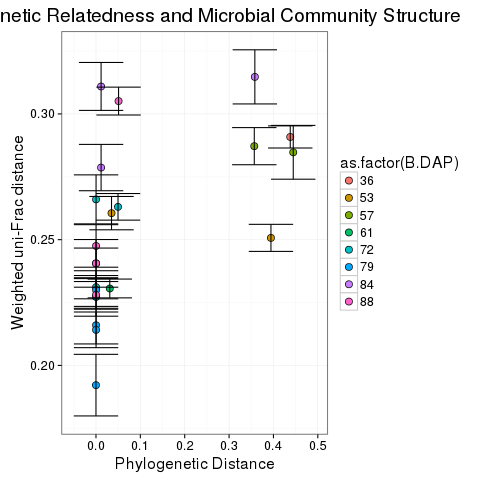

In [261]:
%%R
p = ggplot(B73Means, aes(x = PhyDist.M, y = WUD, fill = as.factor(B.DAP))) +
        geom_point(pch = 21, size = 3) + 
        geom_errorbar(aes(y = WUD,
                  ymin = WUD - WUD.se, ymax = WUD + WUD.se), width = 0.1)+
        ylab("Weighted uni-Frac distance")+
        ggtitle("Phylogenetic Relatedness and Microbial Community Structure") +
        theme_bw(base_size = 16)+
        xlab("Phylogenetic Distance") 
  p

       

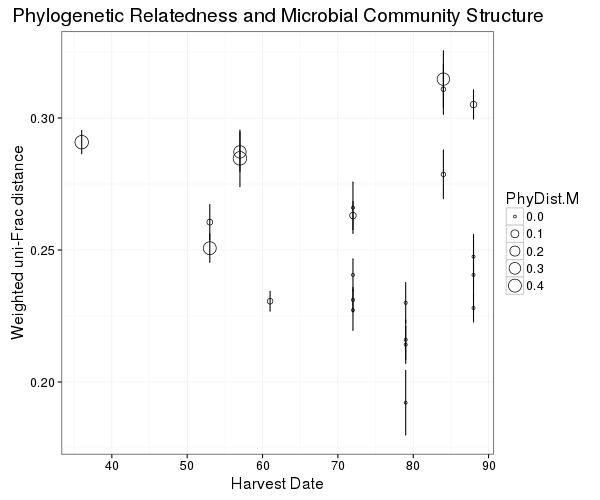

In [267]:
%%R -w 600 -h 500
p = ggplot(B73Means, aes(x = B.DAP, y = WUD)) +
        geom_point(aes(size = PhyDist.M), pch = 21) + 
        geom_errorbar(aes(y = WUD,
                  ymin = WUD - WUD.se, ymax = WUD + WUD.se), width = 0.1)+
        ylab("Weighted uni-Frac distance")+
        ggtitle("Phylogenetic Relatedness and Microbial Community Structure") +
        theme_bw(base_size = 16)+
        xlab("Harvest Date") 
  p

In [263]:
%%R
B73Means$PlantB %>% levels

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 


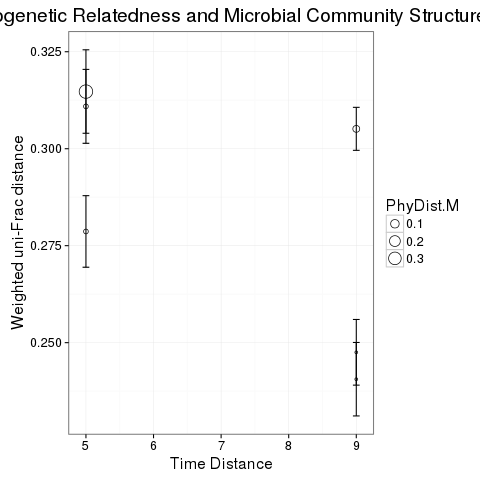

In [264]:
%%R
data = filter(B73Means, PlantB %in% c("Ki3", "Mo18", "ELCOR", "HELAN", "SORBI",  "SORSUD"))
p = ggplot(data, aes(x = time.dist, y = WUD)) +
        geom_point(aes(size = PhyDist.M), pch = 21) + 
        geom_errorbar(aes(y = WUD,
                  ymin = WUD - WUD.se, ymax = WUD + WUD.se), width = 0.1)+
        ylab("Weighted uni-Frac distance")+
        ggtitle("Phylogenetic Relatedness and Microbial Community Structure") +
        theme_bw(base_size = 16)+
        xlab("Time Distance") 
  p

# Mantel test of phylogenetic distance and microbial community distance

## Set up distance matrices

In [200]:
%%R
head(Dist) %>% print
#Remove NAs to trim dataset
Temp = Dist[!is.na(Dist$phy_Dist),]
dim(Temp) %>% print

#Seperate unifrac and phylogenetic distances retaining plot IDs
U = Temp[,c(1,2,3)]
Phy = Temp[,c(1,2,7)]

#Re-cast longform to wide form.  
Udist = acast(U, PlotA~PlotB)


Phydist = acast(Phy, PlotA~PlotB)


#Convert to distance matrices
Phydist = as.matrix(Phydist) %>% dist()
Udist = as.matrix(Udist) %>% dist()

              PlotA             PlotB w_Unif_Dist PlantA PlantB     PlantComp
1 sample5-1.22_Nneg sample5-1.22_Nneg   0.0000000 75-062 75-062 75-062-75-062
2 sample6-4.12_Npos sample5-1.22_Nneg   0.1829650   Oh7B 75-062   Oh7B-75-062
3 sample4-1.03_Npos sample5-1.22_Nneg   0.1722266  SETFA 75-062  SETFA-75-062
4 sample5-2.06_Npos sample5-1.22_Nneg   0.1902666   MS71 75-062   MS71-75-062
5 sample5-4.08_Npos sample5-1.22_Nneg   0.1757315   MS71 75-062   MS71-75-062
6 sample5-4.28_Npos sample5-1.22_Nneg   0.1457043 75-062 75-062 75-062-75-062
  phy_Dist
1  0.00000
2  0.00020
3  0.03111
4  0.00020
5  0.00020
6  0.00000
[1] 30276     7


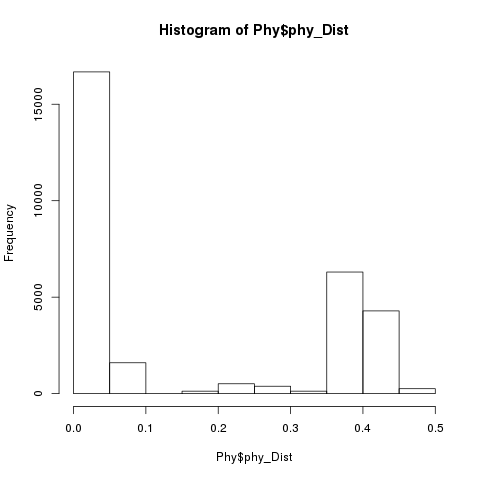

In [201]:
%%R
hist(Phy$phy_Dist)

In [202]:
%%R
#check congruence
Phydist %>% as.matrix %>% tail


                  sample1-1.27_Nneg sample1-1.27_Npos sample1-2.23_Nneg
sample8-4.04_Nneg          5.146372          5.146372          5.146372
sample8-4.04_Npos          5.146372          5.146372          5.146372
sample8-4.07_Nneg          5.146372          5.146372          5.146372
sample8-4.07_Npos          5.146372          5.146372          5.146372
sample8-4.23_Nneg          5.146372          5.146372          5.146372
sample8-4.23_Npos          5.146372          5.146372          5.146372
                  sample1-2.23_Npos sample1-3.08_Nneg sample1-3.08_Npos
sample8-4.04_Nneg          5.146372          5.146372          5.146372
sample8-4.04_Npos          5.146372          5.146372          5.146372
sample8-4.07_Nneg          5.146372          5.146372          5.146372
sample8-4.07_Npos          5.146372          5.146372          5.146372
sample8-4.23_Nneg          5.146372          5.146372          5.146372
sample8-4.23_Npos          5.146372          5.146372          5

In [203]:
%%R
Udist %>% as.matrix %>% tail

                  sample1-1.27_Nneg sample1-1.27_Npos sample1-2.23_Nneg
sample8-4.04_Nneg         1.4593762         1.2416670         1.2999777
sample8-4.04_Npos         1.4173329         1.2156069         1.2678451
sample8-4.07_Nneg         1.0757121         0.5071374         0.7086705
sample8-4.07_Npos         0.9246614         0.4132681         0.5269848
sample8-4.23_Nneg         1.3535248         0.9130161         1.0535161
sample8-4.23_Npos         1.0803858         1.0543128         1.0967538
                  sample1-2.23_Npos sample1-3.08_Nneg sample1-3.08_Npos
sample8-4.04_Nneg         1.2825385         1.4122720         1.4341159
sample8-4.04_Npos         1.2534317         1.3771385         1.3977413
sample8-4.07_Nneg         0.6588443         0.8774782         0.8399237
sample8-4.07_Npos         0.4615399         0.7033234         0.6651700
sample8-4.23_Nneg         1.0114401         1.2244247         1.2136987
sample8-4.23_Npos         1.1229101         1.1458771         1.

## Mantel test, including all plants and maize with arbitrary 0.0002 distance between maize



In [274]:
%%R
M1 = mantel(Udist, Phydist, method="pearson", permutations=999)
print(M1)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Udist, ydis = Phydist, method = "pearson", permutations = 999) 

Mantel statistic r: 0.2544 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0622 0.0787 0.0928 0.1086 
Permutation: free
Number of permutations: 999



           Length Class  Mode     
mantel.res 75     -none- numeric  
n.class     1     -none- numeric  
break.pts  16     -none- numeric  
mult        1     -none- character
n.tests     1     -none- numeric  
call        4     -none- call     

Mantel Correlogram Analysis

Call:
 
mantel.correlog(D.eco = Udist, D.geo = Phydist, nperm = 99) 

        class.index      n.dist  Mantel.cor Pr(Mantel) Pr(corrected)   
D.cl.1   1.7370e-01  1.3718e+04  2.7498e-01       0.01          0.01 **
D.cl.2   5.2109e-01  4.3840e+03 -1.7128e-02       0.34          0.34   
D.cl.3   8.6849e-01  3.8400e+02 -4.9055e-02       0.02          0.04 * 
D.cl.4   1.2159e+00  1.2800e+02  4.2660e-03       0.37          0.68   
D.cl.5   1.5633e+00  7.6800e+02 -1.1444e-01       0.01          0.05 * 
D.cl.6   1.9107e+00  0.0000e+00          NA         NA            NA   
D.cl.7   2.2581e+00  0.0000e+00          NA         NA            NA   
D.cl.8   2.6055e+00  0.0000e+00          NA         NA            NA   
D.cl.9 

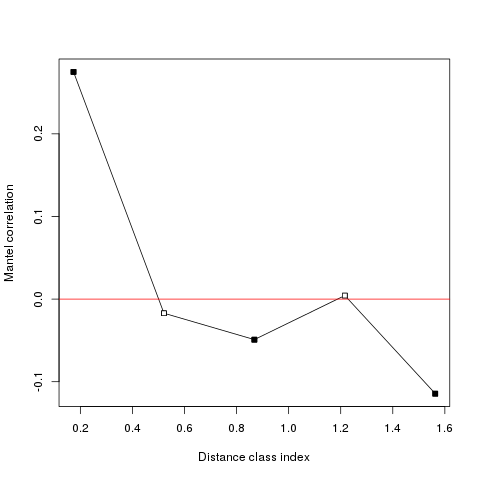

In [205]:
%%R
mcc.correlog <- mantel.correlog(Udist, Phydist, nperm=99)
summary(mcc.correlog) %>% print
mcc.correlog  %>% print
plot(mcc.correlog) 

## Compare to plant functional trait distance matrix

Functional traits include: Resid_logB, Resid_logN, Resid_logCN

In [206]:
%%R

Fun_dist = dist(sd[,c("A_Resid_logB", "A_Resid_logN", "A_Resid_logCN")], method = "euclidian")
#hist(Fun_dist) %>% print


M1 = mantel(wunif.dist, Fun_dist, method="pearson", permutations=999)
M1




Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.07833 
      Significance: 0.041 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0536 0.0725 0.0840 0.1013 
Permutation: free
Number of permutations: 999



### Notes: 
    * If DAP is included as a functional trait functional variation explains an equal portion of the variance as phylogenetic distance:  Mantel r = 0.326 p = 0.001
    * If DAP is not included, considerably less variation, though still significant Mantel R = 0.136 and p = 0.001
    * I should try including both N treatments to broaden variation

### Functional controls all species, CAP

[1] 72 79 61 36 53 57 84 88
Levels: 36 53 57 61 72 79 84 88


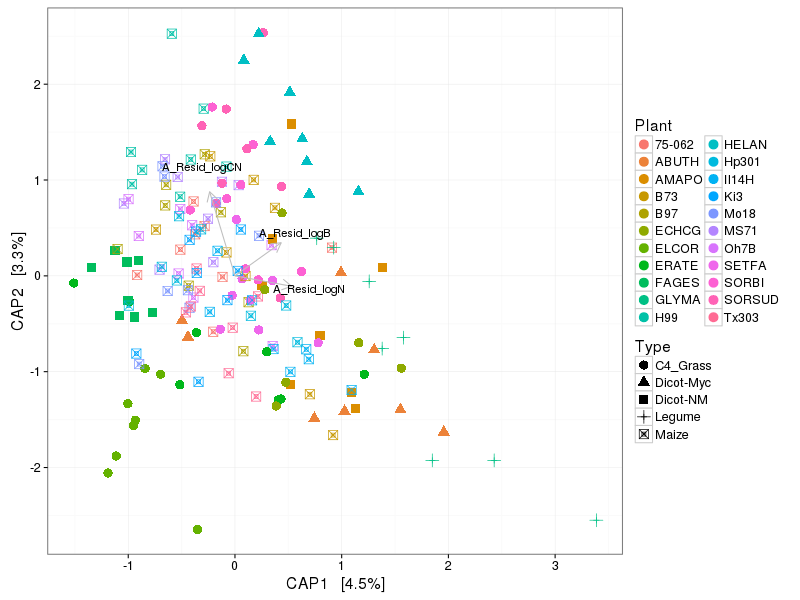

In [207]:
%%R -w 800 -h 600
phy = physeq.Plant

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = wunif.dist,
    formula = ~ A_Resid_logB + A_Resid_logN + A_Resid_logCN + Condition(Library)
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))


# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [208]:
%%R
anova(cap.ord)

Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ A_Resid_logB + A_Resid_logN + A_Resid_logCN + Condition(Library), data = data)
          Df SumOfSqs      F Pr(>F)    
Model      3   0.5531 5.8623  0.001 ***
Residual 169   5.3145                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


###  Include leaf traits (subset of plants from above)

In [ ]:

%%R

phy = subset_samples(physeq.Plant, !is.na(Resid_logSLA) & !is.na(Resid_LeafN))

phy.wunif.dist = distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [ ]:
%%R -w 800 -h 600


sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = phy.wunif.dist,
    formula = ~ Resid_logB + Resid_logN + Resid_logCN + Resid_logSLA + Resid_LeafN  + Condition(Library)
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))


# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [ ]:
%%R
anova(cap.ord)

Notes - a small but significant amount of variation in community composition is captured by plant functional variation  

# Analyze subset from early and late seasons, limiting to two maize

## Early Season, library 1

[1] "ABUTH" "AMAPO" "ECHCG" "H99"   "MS71"  "SETFA"
Importance of components:
                          PC1    PC2    PC3     PC4     PC5
Standard deviation     1.5720 1.2201 0.8380 0.58069 0.02753
Proportion of Variance 0.4942 0.2978 0.1405 0.06744 0.00015
Cumulative Proportion  0.4942 0.7920 0.9324 0.99985 1.00000
                      PC1          PC2         PC3          PC4          PC5
log(Biomass_P)  0.6124938  0.004746739  0.13462856  0.421502735  0.655011019
log(tN_p)       0.4537250 -0.526251156 -0.23984822  0.337227670 -0.588169799
log(Plant_CN)   0.2802683  0.643768576  0.50633069  0.160625016 -0.474173505
NResp.CN       -0.1851747 -0.549190013  0.81479951 -0.005422948  0.013153539
NResp.B        -0.5533037  0.083603463 -0.06386684  0.826306927 -0.001822988


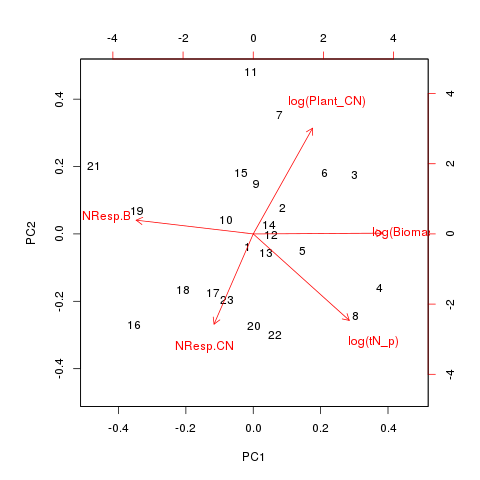

In [209]:
%%R
# PCA of annuals
ES = subset_samples(physeq.Full, Plant %in% c("ECHCG", "AMAPO", "SETFA", "H99",
                                                        "MS71", "ABUTH") & Treatment == "Nneg")



sd = as(sample_data(ES), "data.frame")
sd$Plant %>% levels %>% print

sd = left_join(sd, NResp, by = "Plot")
head(sd)

#sd = left_join(sd, M_GDD, by = "DAP")

fit = prcomp(~log(Biomass_P) + log(tN_p) + log(Plant_CN) + NResp.CN + NResp.B, data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

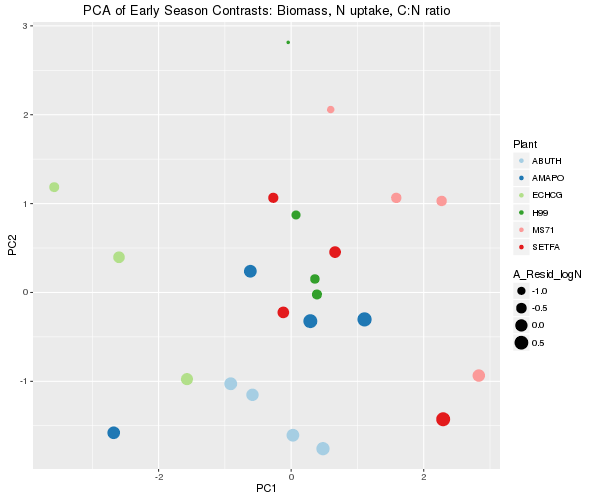

In [210]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sd, S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(ES) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = A_Resid_logN), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Early Season Contrasts: Biomass, N uptake, C:N ratio")
p

In [212]:
%%R

# subset matrices
D_dist = filter(Dist, PlantA %in% c("MS71", "ECHCG",  "H99" , "AMAPO" , "ABUTH",
                                    "SETFA") & PlantB %in% c("MS71", "ECHCG",  "H99" , "AMAPO" , "ABUTH",
                                    "SETFA"))
D_dist$PlantComp %>% unique
#pull matrices
    Temp = D_dist[!is.na(D_dist$phy_Dist),]
    
    #Seperate unifrac and phylogenetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Phy_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Phy_date = acast(Phy_date, PlotA~PlotB)

    #Convert to distance matrices
    Phy_date = as.matrix(Phy_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Phy_date, Udate, method="pearson", permutations=999)
print(M1)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Phy_date, ydis = Udate, method = "pearson", permutations = 999) 

Mantel statistic r: 0.1825 
      Significance: 0.012 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.095 0.128 0.159 0.185 
Permutation: free
Number of permutations: 999



In [214]:
%%R

sd = sample_data(ES)


# Calculate w-unifrac distances
registerDoParallel(cores=28)
ES.wunif.dist = distance(ES, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
sd$logB = log(sd$Biomass_P)
sd$logN = log(sd$tN_p)
sd$logCN = log(sd$Plant_CN)

Fun_dist = dist(sd[,c("A_Resid_logB", "A_Resid_logN", "A_Resid_logCN")], method = "euclidian")


M1 = mantel(ES.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = ES.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.09436 
      Significance: 0.155 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.126 0.169 0.207 0.245 
Permutation: free
Number of permutations: 999



In [217]:
%%R
ES.wunif.dist

                  sample4-2.02_Nneg sample4-4.21_Nneg sample5-2.06_Nneg
sample4-4.21_Nneg         0.1853471                                    
sample5-2.06_Nneg         0.2056788         0.1890167                  
sample5-3.13_Nneg         0.2031210         0.2074062         0.1293945
sample2-2.08_Nneg         0.1732889         0.1947418         0.2221065
sample5-1.17_Nneg         0.3011232         0.2278589         0.1832281
sample5-4.08_Nneg         0.2277475         0.2252953         0.1474853
sample4-1.03_Nneg         0.1517888         0.1509431         0.1827855
sample5-2.11_Nneg         0.2611885         0.2436439         0.1641123
sample2-3.05_Nneg         0.2147556         0.2046821         0.2582996
sample5-4.05_Nneg         0.2643664         0.2258585         0.1636955
sample5-3.16_Nneg         0.2763390         0.2695913         0.2081138
sample2-1.08_Nneg         0.3064641         0.3154118         0.2130379
sample5-1.16_Nneg         0.3276987         0.3085987         0.

In [218]:
%%R
Fun_dist

                  sample4-2.02_Nneg sample4-4.21_Nneg sample5-2.06_Nneg
sample4-4.21_Nneg        0.13420023                                    
sample5-2.06_Nneg        0.49671429        0.45202396                  
sample5-3.13_Nneg        0.39593974        0.31913077        0.73159291
sample2-2.08_Nneg        1.23650925        1.16850134        1.54421109
sample5-1.17_Nneg        0.46495470        0.45818349        0.13538020
sample5-4.08_Nneg        1.14068969        1.15873495        0.76191904
sample4-1.03_Nneg        1.02945084        0.98318713        1.39765417
sample5-2.11_Nneg        0.90782875        0.99129633        0.80641858
sample2-3.05_Nneg        0.45999486        0.44568977        0.89219069
sample5-4.05_Nneg        1.52668144        1.57811543        1.24388200
sample5-3.16_Nneg        0.69626276        0.79463557        0.70745377
sample2-1.08_Nneg        1.02473529        0.98060570        1.39671224
sample5-1.16_Nneg        0.80263437        0.88903892        0.7

[1] SETFA MS71  AMAPO H99   ABUTH ECHCG
Levels: ABUTH AMAPO ECHCG H99 MS71 SETFA


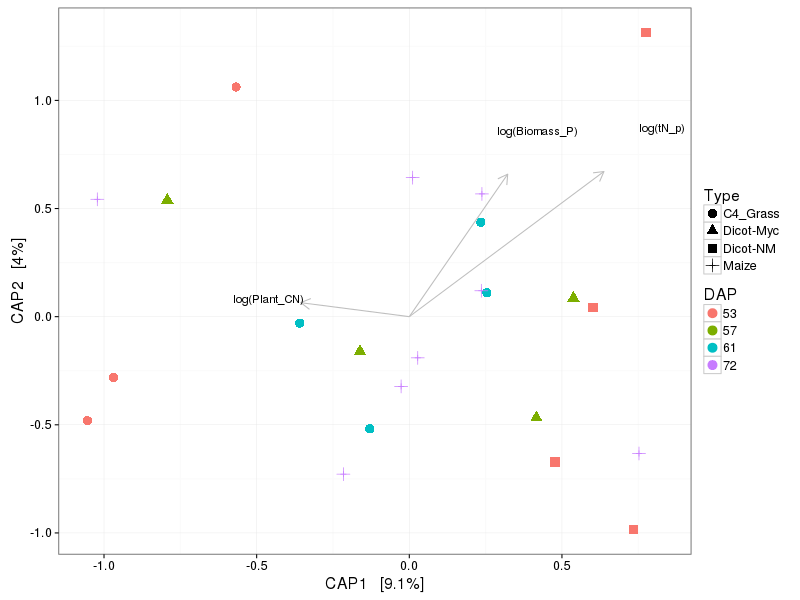

In [228]:
%%R -w 800 -h 600


sample_data(ES)$DAP = as.factor(sample_data(ES)$DAP)
unique(sample_data(ES)$Plant) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = ES, 
    method = "CAP",
    distance = ES.wunif.dist,
    formula = ~ log(Biomass_P) + log(tN_p) + log(Plant_CN) + Condition(DAP)
)

# CAP plot
cap.plot <- plot_ordination(
    ES, 
    cap.ord, 
    color = "DAP", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = DAP), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))


# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [229]:
%%R
anova(cap.ord)

Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ log(Biomass_P) + log(tN_p) + log(Plant_CN) + Condition(DAP), data = data)
         Df SumOfSqs      F Pr(>F)
Model     3  0.06851 0.9967  0.453
Residual 16  0.36657              


# Analyze subset from later season

[1] "ELCOR"  "HELAN"  "Ki3"    "SORBI"  "SORSUD" "Tx303" 
Importance of components:
                          PC1    PC2    PC3     PC4     PC5
Standard deviation     1.4632 1.3787 0.7690 0.60481 0.02821
Proportion of Variance 0.4282 0.3802 0.1183 0.07316 0.00016
Cumulative Proportion  0.4282 0.8084 0.9267 0.99984 1.00000
                       PC1         PC2         PC3        PC4          PC5
log(Biomass_P) -0.56657768  0.36487083 -0.27022495  0.2097429  0.654862880
log(tN_p)      -0.66903583  0.06983457  0.06781845  0.2828743 -0.680365338
log(Plant_CN)   0.22357174  0.55739113 -0.69126732 -0.2320981 -0.328040810
NResp.CN        0.09966201 -0.58848220 -0.61362625  0.5169113 -0.004656492
NResp.B         0.41408207  0.45276510  0.26075171  0.7449317 -0.025003182


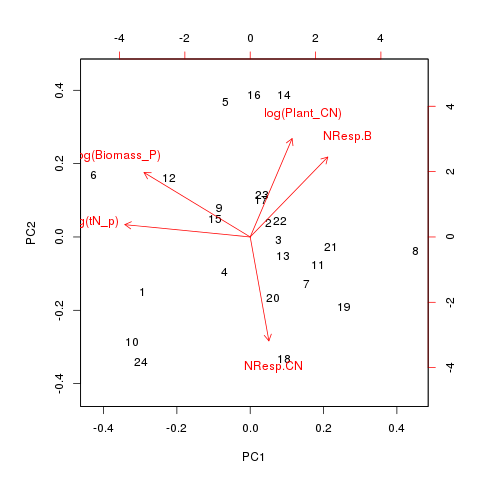

In [230]:
%%R
# PCA of annuals
ES = subset_samples(physeq.Full, Plant %in% c("SORBI", "SORSUD", "HELAN", "ELCOR",
                                                        "Ki3", "Tx303") & Treatment == "Nneg")



sd = as(sample_data(ES), "data.frame")
sd$Plant %>% levels %>% print

sd = left_join(sd, NResp, by = "Plot")
head(sd)

#sd = left_join(sd, M_GDD, by = "DAP")

fit = prcomp(~log(Biomass_P) + log(tN_p) + log(Plant_CN) + NResp.CN + NResp.B, data = sd, 
                na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

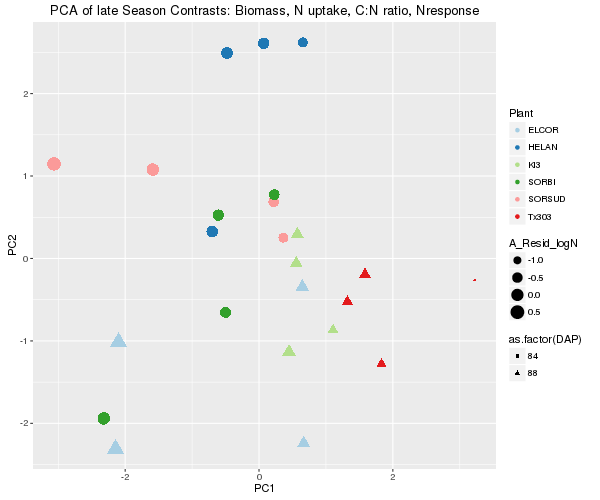

In [231]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sd, S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(ES) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = A_Resid_logN, pch = as.factor(DAP)))
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of late Season Contrasts: Biomass, N uptake, C:N ratio, Nresponse")
p

In [232]:
%%R

# subset matrices
D_dist = filter(Dist, PlantA %in% c("SORBI", "SORSUD", "HELAN", "ELCOR", "Ki3", "Tx303") &
                         PlantB %in% c("SORBI", "SORSUD", "HELAN", "ELCOR", "Ki3", "Tx303"))
                
                                                        
D_dist$PlantComp %>% unique
#pull matrices
    Temp = D_dist[!is.na(D_dist$phy_Dist),]
    
    #Seperate unifrac and phylogenetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Phy_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Phy_date = acast(Phy_date, PlotA~PlotB)

    #Convert to distance matrices
    Phy_date = as.matrix(Phy_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Phy_date, Udate, method="pearson", permutations=999)
print(M1)


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Phy_date, ydis = Udate, method = "pearson", permutations = 999) 

Mantel statistic r: 0.3547 
      Significance: 0.001 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.097 0.143 0.168 0.195 
Permutation: free
Number of permutations: 999



In [ ]:
%%R
E_Fit %>% head

In [233]:
%%R

sd = sample_data(ES)


# Calculate w-unifrac distances
registerDoParallel(cores=28)
ES.wunif.dist = distance(ES, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
sd$logB = log(sd$Biomass_P)
sd$logN = log(sd$tN_p)
sd$logCN = log(sd$Plant_CN)

Fun_dist = dist(sd[,c("logB",  "logN",  "logCN",  "NResp.CN",  "NResp.B")], method = "euclidian")


M1 = mantel(ES.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = ES.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.3847 
      Significance: 0.001 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.116 0.148 0.185 0.216 
Permutation: free
Number of permutations: 999



[1] ELCOR  SORSUD Ki3    SORBI  HELAN  Tx303 
Levels: ELCOR HELAN Ki3 SORBI SORSUD Tx303


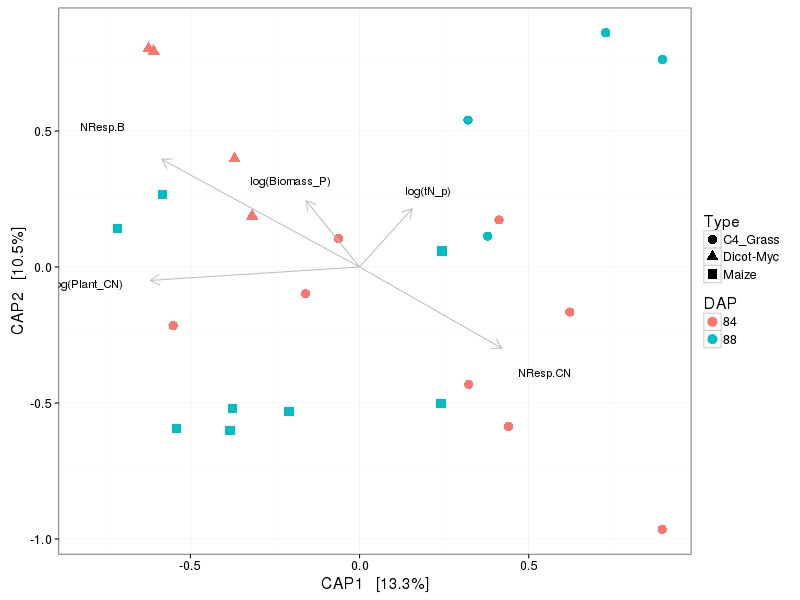

In [234]:
%%R -w 800 -h 600


sample_data(ES)$DAP = as.factor(sample_data(ES)$DAP)
unique(sample_data(ES)$Plant) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = ES, 
    method = "CAP",
    distance = ES.wunif.dist,
    formula = ~ log(Biomass_P) + log(tN_p) + log(Plant_CN) + NResp.B + NResp.CN + Condition(DAP)
)

# CAP plot
cap.plot <- plot_ordination(
    ES, 
    cap.ord, 
    color = "DAP", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = DAP), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))


# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [235]:
%%R
anova(cap.ord)

Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ log(Biomass_P) + log(tN_p) + log(Plant_CN) + NResp.B + NResp.CN + Condition(DAP), data = data)
         Df SumOfSqs      F Pr(>F)    
Model     5  0.16597 1.9598  0.001 ***
Residual 17  0.28794                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Analyze by date of sampling 

#### DAP = 72, Mantel test of phylogenetic distance and MCC weighted-unifrac distance

In [241]:
%%R
head(Temp)

              PlotA             PlotB w_Unif_Dist PlantA PlantB     PlantComp
1 sample5-1.22_Nneg sample5-1.22_Nneg   0.0000000 75-062 75-062 75-062-75-062
2 sample5-2.06_Npos sample5-1.22_Nneg   0.1902666   MS71 75-062   MS71-75-062
3 sample5-4.08_Npos sample5-1.22_Nneg   0.1757315   MS71 75-062   MS71-75-062
4 sample5-4.28_Npos sample5-1.22_Nneg   0.1457043 75-062 75-062 75-062-75-062
5 sample5-1.29_Npos sample5-1.22_Nneg   0.2358625  ERATE 75-062  ERATE-75-062
6 sample5-2.29_Nneg sample5-1.22_Nneg   0.1505018 75-062 75-062 75-062-75-062
  phy_Dist
1  0.00000
2  0.00020
3  0.00020
4  0.00000
5  0.04967
6  0.00000


In [237]:
%%R
# subset matrices
D_dist = filter(Dist, PlantA %in% c("75-062", "ERATE",  "H99" , "Il14H" , "MS71") & PlantB %in% c("75-062", "ERATE",  "H99" , "Il14H" , "MS71"))
D_dist$PlantComp %>% unique
#pull matrices
    Temp = D_dist[!is.na(D_dist$phy_Dist),]
    
    #Seperate unifrac and phylogenetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Phy_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Phy_date = acast(Phy_date, PlotA~PlotB)

    #Convert to distance matrices
    Phy_date = as.matrix(Phy_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Phy_date, Udate, method="pearson", permutations=999)
print(M1)



Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Phy_date, ydis = Udate, method = "pearson", permutations = 999) 

Mantel statistic r: 0.0951 
      Significance: 0.168 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.133 0.181 0.225 0.269 
Permutation: free
Number of permutations: 999



#### Day 72; Mantel test of N economy traits and MCC weighted-unifrac distance

In [238]:
%%R
physeq.Date = subset_samples(physeq.Plant, DAP == "72")
sd = sample_data(physeq.Date)


# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("A_Resid_logB", "A_Resid_logN", "A_Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = date.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: -0.003534 
      Significance: 0.474 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.118 0.151 0.176 0.215 
Permutation: free
Number of permutations: 999



#### Day = 84; Mantel test of phylogenetic distance and MCC weighted-unifrac distance

In [242]:
%%R
# subset matrices
D_dist = filter(Dist, PlantA %in% c("HELAN" , "SORBI" , "SORSUD") & PlantB %in% c("HELAN" , "SORBI" , "SORSUD"))
D_dist$PlantComp %>% unique %>% print
#pull matrices
    Temp = D_dist[!is.na(D_dist$phy_Dist),]
    
    #Seperate unifrac and phylogenetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Phy_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Phy_date = acast(Phy_date, PlotA~PlotB)

    #Convert to distance matrices
    Phy_date = as.matrix(Phy_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Phy_date, Udate, method="pearson", permutations=999)
print(M1)

[1] "SORBI-SORBI"   "SORSUD-SORBI"  "HELAN-SORBI"   "SORBI-SORSUD" 
[5] "SORSUD-SORSUD" "HELAN-SORSUD"  "SORBI-HELAN"   "SORSUD-HELAN" 
[9] "HELAN-HELAN"  

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Phy_date, ydis = Udate, method = "pearson", permutations = 999) 

Mantel statistic r: 0.6092 
      Significance: 0.001 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.107 0.135 0.165 0.209 
Permutation: free
Number of permutations: 999



#### Day 84; Mantel test of N economy traits and MCC weighted-unifrac distance

In [248]:
%%R
physeq.Date = subset_samples(physeq.Plant, DAP == "84")
sd = sample_data(physeq.Date)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("A_Resid_logB", "A_Resid_logN", "A_Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1





Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = date.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.09488 
      Significance: 0.098 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0913 0.1326 0.1558 0.2073 
Permutation: free
Number of permutations: 999



#### CAP Analysis of DAP 84

[1] 84
Levels: 84


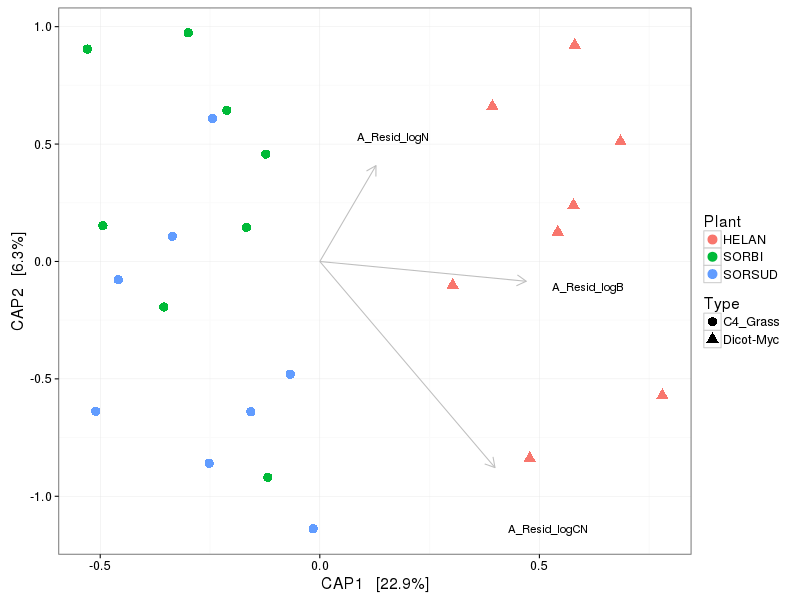

In [246]:
%%R -w 800 -h 600

phy = physeq.Date
sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = date.wunif.dist,
    formula = ~ A_Resid_logB + A_Resid_logN + A_Resid_logCN
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))


# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [249]:
%%R
anova(cap.ord)

Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ A_Resid_logB + A_Resid_logN + A_Resid_logCN, data = data)
         Df SumOfSqs      F Pr(>F)    
Model     3  0.16051 3.1052  0.001 ***
Residual 20  0.34460                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


#### DAP = 88; Mantel test of phylogenetic distance and MCC weighted-unifrac distance

In [250]:
%%R
# subset matrices
D_dist = filter(Dist, PlantA %in% c("ELCOR", "Ki3", "Mo18", "Tx303") & PlantB %in% c("ELCOR", "Ki3", "Mo18", "Tx303"))
    D_dist %>% head() %>% print()
D_dist$PlantComp %>% unique %>% print
#pull matrices
    Temp = D_dist[!is.na(D_dist$phy_Dist),]
    
    #Seperate unifrac and phylogenetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Phy_date = Temp[,c(1,2,7)]


    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Phy_date = acast(Phy_date, PlotA~PlotB)

    #Convert to distance matrices
    Phy_date = as.matrix(Phy_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Phy_date, Udate, method="pearson", permutations=999)
print(M1)

              PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
1 sample8-2.07_Nneg sample8-2.07_Nneg   0.0000000  ELCOR  ELCOR ELCOR-ELCOR
2 sample8-4.23_Nneg sample8-2.07_Nneg   0.2068083    Ki3  ELCOR   Ki3-ELCOR
3 sample8-1.14_Npos sample8-2.07_Nneg   0.2428838  Tx303  ELCOR Tx303-ELCOR
4 sample8-3.28_Npos sample8-2.07_Nneg   0.2563313  Tx303  ELCOR Tx303-ELCOR
5 sample8-2.17_Npos sample8-2.07_Nneg   0.1954499   Mo18  ELCOR  Mo18-ELCOR
6 sample8-2.25_Nneg sample8-2.07_Nneg   0.1608847    Ki3  ELCOR   Ki3-ELCOR
  phy_Dist
1   0.0000
2   0.0509
3   0.0509
4   0.0509
5   0.0509
6   0.0509
 [1] "ELCOR-ELCOR" "Ki3-ELCOR"   "Tx303-ELCOR" "Mo18-ELCOR"  "ELCOR-Ki3"  
 [6] "Ki3-Ki3"     "Tx303-Ki3"   "Mo18-Ki3"    "ELCOR-Tx303" "Ki3-Tx303"  
[11] "Tx303-Tx303" "Mo18-Tx303"  "ELCOR-Mo18"  "Ki3-Mo18"    "Tx303-Mo18" 
[16] "Mo18-Mo18"  

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = Phy_date, ydis = Udate, method = "pearson", permutations = 99

#### DAP = 88 Mantel test of N economy traits and MCC weighted-unifrac distance

In [251]:
%%R
physeq.Date = subset_samples(physeq.Plant, DAP == "88")
sd = sample_data(physeq.Date)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = date.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.1731 
      Significance: 0.033 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.115 0.150 0.182 0.220 
Permutation: free
Number of permutations: 999



# Subset of plants from late mid-late season

In [ ]:
%%R
sd$Plant %>% unique

In [252]:
%%R
# subset matrices
D_dist = filter(Dist, PlantA %in% c("75-062", "Oh7B", "MS71", "ERATE", "B73", "B97", "H99", "Il14H",  
                                    "SORBI",  "SORSUD", "ELCOR","Ki3", "HELAN", "Tx303",  "Hp301","Mo18") & PlantB %in% 
                c("75-062", "Oh7B", "MS71", "ERATE", "B73", "B97", "H99", "Il14H",  
                                    "SORBI",  "SORSUD", "ELCOR","Ki3", "HELAN", "Tx303",  "Hp301","Mo18"))
    D_dist %>% head() %>% print()
D_dist$PlantComp %>% unique %>% print
#pull matrices
    Temp = D_dist[!is.na(D_dist$phy_Dist),]
    
    #Seperate unifrac and phylogenetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Phy_date = Temp[,c(1,2,7)]


    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Phy_date = acast(Phy_date, PlotA~PlotB)

    #Convert to distance matrices
    Phy_date = as.matrix(Phy_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Phy_date, Udate, method="pearson", permutations=999)
print(M1)

              PlotA             PlotB w_Unif_Dist PlantA PlantB     PlantComp
1 sample5-1.22_Nneg sample5-1.22_Nneg   0.0000000 75-062 75-062 75-062-75-062
2 sample6-4.12_Npos sample5-1.22_Nneg   0.1829650   Oh7B 75-062   Oh7B-75-062
3 sample5-2.06_Npos sample5-1.22_Nneg   0.1902666   MS71 75-062   MS71-75-062
4 sample5-4.08_Npos sample5-1.22_Nneg   0.1757315   MS71 75-062   MS71-75-062
5 sample5-4.28_Npos sample5-1.22_Nneg   0.1457043 75-062 75-062 75-062-75-062
6 sample5-1.29_Npos sample5-1.22_Nneg   0.2358625  ERATE 75-062  ERATE-75-062
  phy_Dist
1  0.00000
2  0.00020
3  0.00020
4  0.00020
5  0.00000
6  0.04967
  [1] "75-062-75-062" "Oh7B-75-062"   "MS71-75-062"   "ERATE-75-062" 
  [5] "B73-75-062"    "B97-75-062"    "H99-75-062"    "Il14H-75-062" 
  [9] "SORBI-75-062"  "SORSUD-75-062" "ELCOR-75-062"  "Ki3-75-062"   
 [13] "HELAN-75-062"  "Tx303-75-062"  "Hp301-75-062"  "Mo18-75-062"  
 [17] "75-062-Oh7B"   "Oh7B-Oh7B"     "MS71-Oh7B"     "ERATE-Oh7B"   
 [21] "B73-Oh7B"      "B97-

### Mantel test of N economy traits and MCC weighted-unifrac distance

In [254]:
%%R

physeq.Date = subset_samples(physeq.Plant, DAP %in% c("72", "79", "84", "88"))
sd = sample_data(physeq.Date)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("A_Resid_logB", "A_Resid_logN", "A_Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = date.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.2163 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0654 0.0844 0.1011 0.1240 
Permutation: free
Number of permutations: 999



#### CAP analysis of N economy traits and MCC

[1] 72 79 84 88
Levels: 72 79 84 88


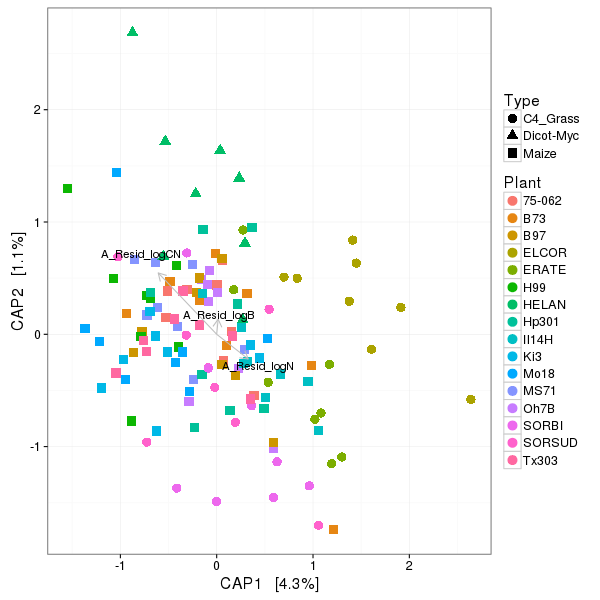

In [255]:
%%R -w 600 -h 600
phy = physeq.Date

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = date.wunif.dist,
    formula = ~ A_Resid_logB + A_Resid_logN + A_Resid_logCN + Condition(Library) + Condition(DAP)
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [256]:
%%R
anova(cap.ord)

Permutation test for capscale under reduced model
Permutation: free
Number of permutations: 999

Model: capscale(formula = distance ~ A_Resid_logB + A_Resid_logN + A_Resid_logCN + Condition(Library) + Condition(DAP), data = data)
          Df SumOfSqs      F Pr(>F)    
Model      3  0.19671 2.7018  0.001 ***
Residual 120  2.91219                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


#### Include leaf traits (subset of plants from above)

In [ ]:
%%R
physeq.Date = subset_samples(physeq.Plant, DAP %in% c("72", "79", "84", "88"))

physeq.Date = subset_samples(physeq.Date, !is.na(Resid_logSLA) & !is.na(Resid_LeafN))

date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [ ]:
%%R -w 600 -h 600

sample_data(physeq.Date)$DAP = as.factor(sample_data(physeq.Date)$DAP)
unique(sample_data(physeq.Date)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = physeq.Date, 
    method = "CAP",
    distance = date.wunif.dist,
    formula = ~ Resid_logB + Resid_logN + Resid_logCN + Resid_logSLA + Resid_LeafN + Condition(Library)
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [ ]:
%%R
anova(cap.ord)

# Subset of annuals from late mid-late season

In [257]:
%%R
# subset matrices
D_dist = filter(Dist, PlantA %in% c( "ERATE", "SORBI",  "SORSUD", "ELCOR","HELAN", "B73") & PlantB %in% 
                                    
                c("ERATE", "SORBI",  "SORSUD", "ELCOR","HELAN", "B73"))
    D_dist %>% head() %>% print()
D_dist$PlantComp %>% unique %>% print
#pull matrices
    Temp = D_dist[!is.na(D_dist$phy_Dist),]
    
    #Seperate unifrac and phylogenetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Phy_date = Temp[,c(1,2,7)]


    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Phy_date = acast(Phy_date, PlotA~PlotB)

    #Convert to distance matrices
    Phy_date = as.matrix(Phy_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Phy_date, Udate, method="pearson", permutations=999)
print(M1)

              PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
1 sample5-1.29_Npos sample5-1.29_Npos   0.0000000  ERATE  ERATE ERATE-ERATE
2 sample6-2.26_Nneg sample5-1.29_Npos   0.2831953    B73  ERATE   B73-ERATE
3 sample6-3.18_Nneg sample5-1.29_Npos   0.2582766    B73  ERATE   B73-ERATE
4 sample5-3.11_Nneg sample5-1.29_Npos   0.1783563  ERATE  ERATE ERATE-ERATE
5 sample6-4.30_Npos sample5-1.29_Npos   0.2177385    B73  ERATE   B73-ERATE
6 sample6-1.12_Npos sample5-1.29_Npos   0.2506999    B73  ERATE   B73-ERATE
  phy_Dist
1  0.00000
2  0.04967
3  0.04967
4  0.00000
5  0.04967
6  0.04967
 [1] "ERATE-ERATE"   "B73-ERATE"     "SORBI-ERATE"   "SORSUD-ERATE" 
 [5] "ELCOR-ERATE"   "HELAN-ERATE"   "ERATE-B73"     "B73-B73"      
 [9] "SORBI-B73"     "SORSUD-B73"    "ELCOR-B73"     "HELAN-B73"    
[13] "ERATE-SORBI"   "B73-SORBI"     "SORBI-SORBI"   "SORSUD-SORBI" 
[17] "ELCOR-SORBI"   "HELAN-SORBI"   "ERATE-SORSUD"  "B73-SORSUD"   
[21] "SORBI-SORSUD"  "SORSUD-SORSUD" "ELCOR-SO

* Note that the phylogenetic test is calculated on both Npos and Nneg plots, need to correct to match below

### Mantel test of N economy traits and MCC weighted-unifrac distance

In [258]:
%%R

physeq.Date = subset_samples(physeq.Plant, DAP %in% c("72", "79", "84", "88") & Type != "Maize" & Treatment == "Nneg"| 
                            Plant == "B73" & Treatment == "Nneg")
sd = sample_data(physeq.Date)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("A_Resid_logB", "A_Resid_logN", "A_Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1


Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = date.wunif.dist, ydis = Fun_dist, method = "pearson",      permutations = 999) 

Mantel statistic r: 0.4859 
      Significance: 0.001 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.103 0.140 0.173 0.201 
Permutation: free
Number of permutations: 999



#### CAP analysis of N economy traits and MCC

[1] 79 72 88 84
Levels: 72 79 84 88


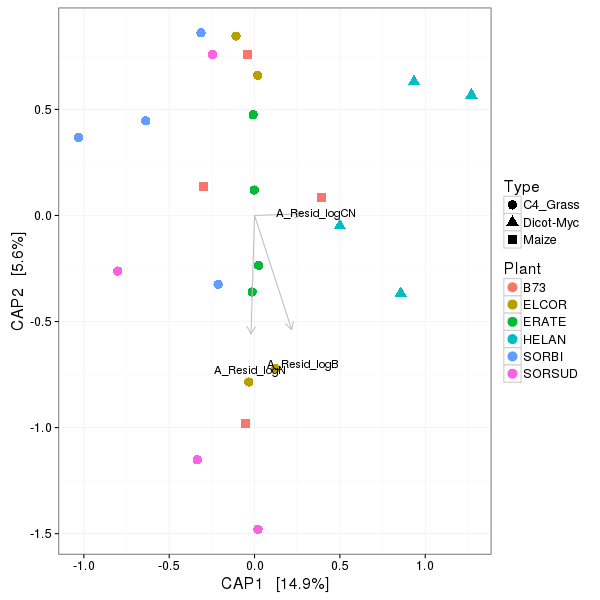

In [260]:
%%R -w 600 -h 600
phy = physeq.Date

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = date.wunif.dist,
    formula = ~ A_Resid_logB + A_Resid_logN + A_Resid_logCN + Condition(Library) + Condition(DAP)
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [ ]:
%%R
anova(cap.ord)

# Subset to all annuals 

In [ ]:
%%R
sample_data(physeq.Plant)$Plant %>% levels 

In [ ]:
%%R
# subset matrices
D_dist = filter(Dist, PlantA %in% c( "ABUTH" , "AMAPO", "ECHCG" , "ERATE", "FAGES",  "GLYMA", "SETFA", "SORBI",   
                                    "SORSUD", "ELCOR","HELAN", "B73") & PlantB %in% 
                                    
                c("ABUTH" , "AMAPO", "ECHCG" , "ERATE", "FAGES",  "GLYMA", "SETFA", "SORBI",   
                                    "SORSUD", "ELCOR","HELAN", "B73"))
    D_dist %>% head() %>% print()
D_dist$PlantComp %>% unique %>% print
#pull matrices
    Temp = D_dist[!is.na(D_dist$phy_Dist),]
    
    #Seperate unifrac and phylogenetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Phy_date = Temp[,c(1,2,7)]


    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Phy_date = acast(Phy_date, PlotA~PlotB)

    #Convert to distance matrices
    Phy_date = as.matrix(Phy_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Phy_date, Udate, method="pearson", permutations=999)
print(M1)

In [ ]:
%%R

physeq.Date = subset_samples(physeq.Plant, Type != "Maize" & Plant != "FAGES" | Plant == "B73")
sd = sample_data(physeq.Date)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("A_Resid_logB", "A_Resid_logN", "A_Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1

#### CAP analysis of N economy traits and MCC

In [ ]:
%%R -w 600 -h 600
phy = physeq.Date

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = date.wunif.dist,
    formula = ~  d15N + A_Resid_logB + Condition(Plant)
)
#formula = ~ A_Resid_logB + A_Resid_logN + A_Resid_logCN + d15N + Condition(Library)
# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [ ]:
%%R
anova(cap.ord)

# Maize distance analysis

In [ ]:
%%R
NAM_hc = hclust(as.dist(NAMdist), "average")
plot(NAM_hc)

In [ ]:
%%R
physeq.Maize = subset_samples(physeq.Full, Type == "Maize" & Plant != "75-062")
as(sample_data(physeq.Maize), "data.frame") %>%

group_by(Plant) %>%
   summarise(DATE = first(DAP)) %>% 
    arrange(DATE) %>%
   print()

In [ ]:
%%R
#Use melt to join genetic distance matrix with unifrac distance
#head(ud.m) ##Use formated unifrac distance from above
#melt 
NAM.m = melt(as.matrix(NAMdist))

#set column names and create comparison column
colnames(NAM.m) = c("PlantA", "PlantB", "gene_Dist")

NAM.m$PlantComp = paste(NAM.m$PlantA, NAM.m$PlantB, sep = "-")
NAM.m %>% head

#Join with unifrac DistanceMatrix
Dist = left_join(ud.m, NAM.m[,c(3,4)], by = "PlantComp")
head(Dist)

In [ ]:
%%R
dim(Dist) %>% print
D.s = filter(Dist, PlotA != PlotB)

dim(D.s) %>% print
plot(w_Unif_Dist~gene_Dist, data = D.s)
m = lm(w_Unif_Dist~gene_Dist, data = D.s)
abline(m) 


In [ ]:
%%R
head(Dist)
#Remove NAs to trim dataset
Temp = Dist[!is.na(Dist$gene_Dist),]


#Seperate unifrac and phylogenetic distances retaining plot IDs
U = Temp[,c(1,2,3)]
Gene = Temp[,c(1,2,7)]

#Re-cast longform to wide form.  
Udist = acast(U, PlotA~PlotB) 


Genedist = acast(Gene, PlotA~PlotB)
Genedist

## Overall maize genetic distance vs MCC

In [ ]:
%%R
M1 = mantel(as.dist(Genedist), as.dist(Udist), method="pearson", permutations=999)
print(M1)

### Functional comparison of maize - Mantel test

In [ ]:
%%R
sd = sample_data(physeq.Maize)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
maize.wunif.dist = distance(physeq.Maize, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(maize.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1

In test of genetic vs functional control of maize, growth residuals were not significantly correlated with microbial community similarity in mantel test.  Significance was gained by including DAP, however, this is now capturing day to day sampling variation.  

### Functional comparison of maize, CAP

In [ ]:
%%R -w 600 -h 600
phy = physeq.Maize

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = maize.wunif.dist,
    formula = ~ Resid_logB + Resid_logN + Resid_logCN + Condition(Library)
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [ ]:
%%R
anova(cap.ord)

Notes - a small but significant amount of variation in community composition is captured by maize functional variation.  

Check how to constrain by DAP to control for differences from sampling date?  Still significant albeit small portion of variation captured when controlling for DAP.  

### Maize by date

#### DAP = 72; Mantel test maize genetic distance vs MCC

In [ ]:
%%R

# subset matrices
D_dist = filter(Dist, PlantA %in% c("H99" , "Il14H" , "MS71") & PlantB %in% c("H99" , "Il14H" , "MS71"))
D_dist$PlantComp %>% unique %>% print
#pull matrices
    Temp = D_dist[!is.na(D_dist$gene_Dist),]
    
    #Seperate unifrac and genetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Gene_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Gene_date = acast(Gene_date, PlotA~PlotB)

    #Convert to distance matrices
    Gene_date = as.matrix(Gene_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Gene_date, Udate, method="pearson", permutations=999)
print(M1)

#### DAP = 72; Mantel test N economy traits vs MCC

In [ ]:
%%R
physeq.Date = subset_samples(physeq.Plant, Plant %in% c("H99" , "Il14H" , "MS71"))
sd = sample_data(physeq.Date)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1

#### DAP 72; CAP analysis N economy and MCC

In [ ]:
%%R -w 600 -h 600
phy = physeq.Date

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = date.wunif.dist,
    formula = ~ Resid_logB + Resid_logN + Resid_logCN
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [ ]:
%%R
anova(cap.ord)

#### DAP = 79;  Mantel test maize genetic distance vs MCC

In [ ]:
%%R

# subset matrices
D_dist = filter(Dist, PlantA %in% c("B73" ,  "B97" ,  "Hp301" , "Oh7B" ) & PlantB %in% c("B73" ,  "B97" ,  "Hp301" , "Oh7B"))
 D_dist$PlantComp %>% unique %>% print

#pull matrices
    Temp = D_dist[!is.na(D_dist$gene_Dist),]
    
    #Seperate unifrac and genetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Gene_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Gene_date = acast(Gene_date, PlotA~PlotB)

    #Convert to distance matrices
    Gene_date = as.matrix(Gene_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Gene_date, Udate, method="pearson", permutations=999)
print(M1)

#### DAP = 79;  Mantel test N economy traits vs MCC

In [ ]:
%%R
physeq.Date = subset_samples(physeq.Plant, Plant %in% c("B73" ,  "B97" ,  "Hp301" , "Oh7B"))
sd = sample_data(physeq.Date)
D_dist$PlantComp %>% unique %>% print
# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1

#### DAP 79; CAP analysis N economy vs MCC

In [ ]:
%%R -w 600 -h 600
phy = physeq.Date

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = date.wunif.dist,
    formula = ~ Resid_logB + Resid_logN + Resid_logCN + Condition(Library)
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [ ]:
%%R
anova(cap.ord)

#### DAP = 88; Mantel test maize genetic distance vs MCC

In [ ]:
%%R

# subset matrices
D_dist = filter(Dist, PlantA %in% c("Ki3" ,  "Mo18" , "Tx303" ) & PlantB %in% c("Ki3" ,  "Mo18" , "Tx303"))
D_dist$PlantComp %>% unique %>% print
#pull matrices
    Temp = D_dist[!is.na(D_dist$gene_Dist),]
    
    #Seperate unifrac and genetic distances retaining plot IDs

    Udate = Temp[,c(1,2,3)]
    Gene_date = Temp[,c(1,2,7)]

    #Re-cast longform to wide form.  
    Udate = acast(Udate, PlotA~PlotB)
    Gene_date = acast(Gene_date, PlotA~PlotB)

    #Convert to distance matrices
    Gene_date = as.matrix(Gene_date) %>% dist()
    Udate = as.matrix(Udate) %>% dist()

M1 = mantel(Gene_date, Udate, method="pearson", permutations=999)
print(M1)

#### DAP = 88; Mantel test N economy vs MCC

In [ ]:
%%R
physeq.Date = subset_samples(physeq.Plant, Plant %in% c("Ki3" ,  "Mo18" , "Tx303"))
sd = sample_data(physeq.Date)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Date, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("Resid_logB", "Resid_logN", "Resid_logCN")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1

#### DAP = 88; CAP analysis N economy vs MCC

In [ ]:
%%R -w 600 -h 600
phy = physeq.Date

sample_data(phy)$DAP = as.factor(sample_data(phy)$DAP)
unique(sample_data(phy)$DAP) %>% print
# CAP ordinate
cap.ord = ordinate(
    physeq = phy, 
    method = "CAP",
    distance = date.wunif.dist,
    formula = ~ Resid_logB + Resid_logN + Resid_logCN
)

# CAP plot
cap.plot <- plot_ordination(
    phy, 
    cap.ord, 
    color = "Plant", 
    axes = c(1,2)
    ) + 
    aes(shape = Type) + 
    geom_point(aes(colour = Plant), 
        alpha= 1, 
        size = 4) + 
    #geom_point(colour = "grey90", 
    #    size = 1.5) + 
    theme_bw(base_size = 16)
    #scale_color_manual(values = c("#a65628", "red", "#ffae19", "#4daf4a", 
    #    "#1919ff", "darkorchid3", "magenta"))

# Now add the environmental variables as arrows
arrowmat <- vegan::scores(cap.ord, display = "bp")


# Add labels, make a data.frame
arrowdf <- data.frame(labels = rownames(arrowmat), arrowmat)

# Define the arrow aesthetic mapping
arrow_map <- aes(xend = CAP1, 
    yend = CAP2, 
    x = 0, 
    y = 0, 
    shape = NULL, 
    color = NULL, 
    label = labels)

label_map <- aes(x = 1.3 * CAP1, 
    y = 1.3 * CAP2, 
    shape = NULL, 
    color = NULL, 
    label = labels)

arrowhead = arrow(length = unit(0.02, "npc"))

# Make a new graphic
cap.plot + 
geom_segment(arrow_map, 
    size = .5, 
    data = arrowdf, 
    color = "gray", 
    arrow = arrowhead
    ) + 
geom_text(label_map, 
    size = 4,  
    data = arrowdf, 
    show_guide = FALSE)

In [ ]:
%%R
anova(cap.ord)

# Time vs MCC mantel test

In [ ]:
%%R
sample_data(physeq.Nneg)$DAP

In [ ]:
%%R
sd = sample_data(physeq.Nneg)

# Calculate w-unifrac distances
registerDoParallel(cores=28)
date.wunif.dist = distance(physeq.Nneg, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

#Calculate functional distances
Fun_dist = dist(sd[,c("DAP")], method = "euclidian")


M1 = mantel(date.wunif.dist, Fun_dist, method="pearson", permutations=999)
M1

In [ ]:
%%R
mcc.correlog <- mantel.correlog(date.wunif.dist, Fun_dist, nperm=99)
summary(mcc.correlog) %>% print
mcc.correlog  %>% print
plot(mcc.correlog) 

# Ignore below this point

# Compare plant phylogenetic distance to l2f

In [ ]:
%%R
# log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'
# l2f = read.csv(log2foldFile, header = TRUE)
# colnames(l2f)

### Spread by plant to make matrix of log2fold change in each OTU by plant combo

In [ ]:
%%R
# df = l2f[,c(1,11,13)]
# l2f_m = spread(df, Plant, log2FoldChange, fill = 0, drop = TRUE)
# rownames(l2f_m) = l2f_m$OTU
# l2f_m = l2f_m[,-1]
# l2f_m %>% head

In [ ]:
%%R
# dim(l2f_m)

### recode all negative log2fold changes with 0

In [ ]:
%%R
# l2f_me = l2f_m
# l2f_me[l2f_me < 0] = 0 
# head(l2f_me)

## Calculate pairwise weighted Unifrac distances between samples

need to figure out how to run unifrac measure outside of phyloseq

In [ ]:
%%R
# physeq.Full

In [ ]:
%%R
# #provide fast tree for unifrac calculation
# #treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'
# #Tree = read.tree(treeFile)
# Tree = phy_tree(physeq.Full)
# str(Tree)


In [ ]:
%%R
# l2f_wunif = picante::unifrac(as.matrix(t(l2f_me)), Tree)

In [ ]:
%%R
# l2f_bray = vegdist(as.matrix(t(l2f_me)), method = "bray")

In [ ]:
%%R
# hc_unif = hclust(l2f_wunif, "average")
# plot(hc_unif) %>% print

# hc_bray = hclust(l2f_bray, "average")
# plot(hc_bray, main = "Cluster Dendrogram, \n Bray-Curtis Distance")

# Mantel test of phylogenetic distance and l2f unifrac distance

### Maize

In [ ]:
%%R
# NAMdist %>% print

# #subset column and rows of log2fold change so that only NAM lines are included
# NLU = as.matrix(l2f_wunif)
# NLU = NLU[c(4,5,11,13:18,22),c(4,5,11,13:18,22)]
# NLU

# NLB = as.matrix(l2f_bray)
# NLB = NLB[c(4,5,11,13:18,22),c(4,5,11,13:18,22)]
# NLB

In [ ]:
%%R
# M1 = mantel(as.dist(NAMdist), as.dist(NLU), method="pearson", permutations=999)
# print(M1)

In [ ]:
%%R
# M1 = mantel(as.dist(NAMdist), as.dist(NLB), method="pearson", permutations=999)
# print(M1)

### Species

In [ ]:
%%R

# #Organize log2fold change distance matrix so that only plants with cholorplast distances are included 
# #and column and row order is congruent with phylogenetic distance matrix
# l2f_wunif.t = as.matrix(l2f_wunif) %>% as.data.frame()
#     temp1 = l2f_wunif.t[c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR"), c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR")]

#     SLU = as.matrix(temp1)

#     SLU = as.dist(SLU)
#     SLU %>% print

# #Remove ginkgo so that matrices are congruent
# p.temp = as.matrix(phydist) %>% as.data.frame()
#     temp2 = p.temp[-12, -12] #remove ginkgo

#     temp2 = as.matrix(temp2)
#     phydist = as.dist(temp2)

#     phydist %>% print

# l2f_bray.t = as.matrix(l2f_bray) %>% as.data.frame()
#     temp2 = l2f_bray.t[c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR"), c("FAGES", "AMAPO", "HELAN", "ABUTH", "GLYMA", "SORBI", "B73", "ECHCG",
#                     "SETFA", "ERATE", "ELCOR")]

#     SLB = as.matrix(temp2)
#     SLB = as.dist(SLB)
#     SLB %>% print


In [ ]:
%%R
# m1 = mantel(phydist, SLU, method="pearson", permutations=999)
# print(m1)

In [ ]:
%%R
# m1 = mantel(phydist, SLB, method="pearson", permutations=999)
# print(m1)